# 04 — Model Explainability (LightGBM + SHAP)

This notebook focuses on **explaining** the final LightGBM model used to predict  
hospital length of stay for diabetic patients.

Instead of building new models, we:
- Rebuild the feature matrix from the processed dataset
- Reload or retrain the tuned LightGBM model
- Analyze global feature importance
- Use **SHAP** to explain predictions globally and at the individual patient level

> Goal: Turn a high-performing model into an **interpretable clinical decision-support tool**.


## 🔄 Workflow

1. Load the processed dataset (`cleaned_data.csv`)  
2. Recreate the feature matrix (X, y) consistently with the training notebook  
3. Rebuild and fit the tuned **LightGBM** model  
4. Evaluate overall performance on the test set  
5. Inspect global feature importance  
6. Use **SHAP** for:
   - Global explanation (summary plots)
   - Local explanation (single-patient case)


## 1️⃣ Load Processed Dataset

We start from the **processed** dataset created in `02_data_preprocessing.ipynb`.  
This file already contains engineered features and one-hot encoded categorical variables.

A quick preview confirms that the structure matches the modeling notebook.


In [ ]:
import os
import numpy as np
import pandas as pd

from pandas.api.types import is_object_dtype, is_bool_dtype

from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error

import matplotlib.pyplot as plt

from lightgbm import LGBMRegressor
import shap

plt.style.use("seaborn-v0_8")

PROC_PATH = "../data/processed/cleaned_data.csv"
df = pd.read_csv(PROC_PATH)

print("Loaded:", df.shape)
df.head(3)


Loaded: (101766, 291)


,time_in_hospital,payer_code,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,metformin,...,admission_source_id_20,admission_source_id_22,admission_source_id_25,admission_source_id_3,admission_source_id_4,admission_source_id_5,admission_source_id_6,admission_source_id_7,admission_source_id_8,admission_source_id_9
0,1,Unknown,41,0,1,0,0,0,1,No,...,False,False,False,False,False,False,False,False,False,False
1,3,Unknown,59,0,18,0,0,0,9,No,...,False,False,False,False,False,False,False,True,False,False
2,2,Unknown,11,5,13,2,0,1,6,No,...,False,False,False,False,False,False,False,True,False,False


## 2️⃣ Rebuild Feature Matrix (X, y)

To ensure full consistency with the training pipeline,  
we reconstruct the modeling matrix:

- Copy the processed dataframe
- Make sure all features are numeric and clean
- Split into **features** `X` and **target** `y`
- Apply the same train–test split configuration as in the training notebook

This guarantees that performance and SHAP explanations are directly comparable.


In [ ]:
TARGET = "time_in_hospital"
assert TARGET in df.columns, "Target column not found in data."

df_model = df.copy()

obj_cols = [c for c in df_model.columns if c != TARGET and is_object_dtype(df_model[c])]
bool_cols = [c for c in df_model.columns if c != TARGET and is_bool_dtype(df_model[c])]

print("Object cols to encode:", len(obj_cols))
print(obj_cols[:15])

if obj_cols:
    df_model = pd.get_dummies(df_model, columns=obj_cols, drop_first=True)

for c in bool_cols:
    if c in df_model.columns:
        df_model[c] = df_model[c].astype(np.uint8)

df_model = df_model.fillna(0)

print("After object/bool encoding ->", df_model.shape)


Object cols to encode: 27
['payer_code', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone']
After object/bool encoding -> (101766, 333)


In [ ]:
def sanitize_colnames(cols: pd.Index) -> pd.Index:
    cols = cols.astype(str)
    cols = cols.str.replace(r"[\[\]\(\)<>]", "", regex=True)  
    cols = cols.str.replace(r"[^\w]+", "_", regex=True)     
    cols = cols.str.strip("_")                               
    return cols

old_cols = df_model.columns.copy()
df_model.columns = sanitize_colnames(df_model.columns)

if TARGET not in df_model.columns:
    raise RuntimeError("Target column name changed unexpectedly after sanitization.")

print("Example columns:", df_model.columns[:10].tolist())


Example columns: ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'age_mid', 'meds_per_day']


In [ ]:
feature_cols = [c for c in df_model.columns if c != TARGET]

df_model[feature_cols] = df_model[feature_cols].astype(np.float32)

df_model = df_model.fillna(0)

print("Dtype counts:\n", df_model.dtypes.value_counts())

X = df_model.drop(columns=[TARGET])
y = df_model[TARGET].astype(float)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("X_train:", X_train.shape, "| X_test:", X_test.shape)
print("y_train:", y_train.shape, "| y_test:", y_test.shape)


Dtype counts:
 float32    332
int64        1
Name: count, dtype: int64
X_train: (81412, 332) | X_test: (20354, 332)
y_train: (81412,) | y_test: (20354,)


## 3️⃣ Refit the Tuned LightGBM Model

Using the **best hyperparameters** found in `03_model_training.ipynb`,  
we refit the final LightGBM model on the training data.

This model will be used consistently for:
- Performance reporting  
- Feature importance analysis  
- SHAP-based explainability


In [7]:
best_params_lgbm = {
    "subsample": 0.6,
    "reg_lambda": 0.1,
    "reg_alpha": 0.0,
    "num_leaves": 127,
    "n_estimators": 600,
    "max_depth": -1,
    "learning_rate": 0.05,
    "colsample_bytree": 1.0,
    "random_state": 42,
    "n_jobs": -1
}

lgbm_final = LGBMRegressor(**best_params_lgbm)

lgbm_final.fit(X_train, y_train)

print("✅ Final LightGBM fitted.")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017829 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1379
[LightGBM] [Info] Number of data points in the train set: 81412, number of used features: 301
[LightGBM] [Info] Start training from score 4.401513
✅ Final LightGBM fitted.


## 4️⃣ Test Set Performance (Sanity Check)

Before diving into explainability, we verify that the refitted model  
achieves the expected performance on the **held-out test set**:

- R²  
- RMSE  
- MAE  

This confirms that the model in this notebook is equivalent to the one selected during training.


In [8]:
y_pred = lgbm_final.predict(X_test)

r2 = r2_score(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"LGBM Test R²: {r2:.4f}")
print(f"LGBM Test RMSE: {rmse:.4f}")
print(f"LGBM Test MAE: {mae:.4f}")


LGBM Test R²: 0.9996
LGBM Test RMSE: 0.0577
LGBM Test MAE: 0.0108


## 5️⃣ Learning Curve — LightGBM

The learning curve illustrates how the LightGBM model behaves  
as more training data is used:

- The **training curve** shows fit on the training folds  
- The **validation curve** shows generalization across folds  

A small gap between the two curves suggests that the model is not severely overfitting.


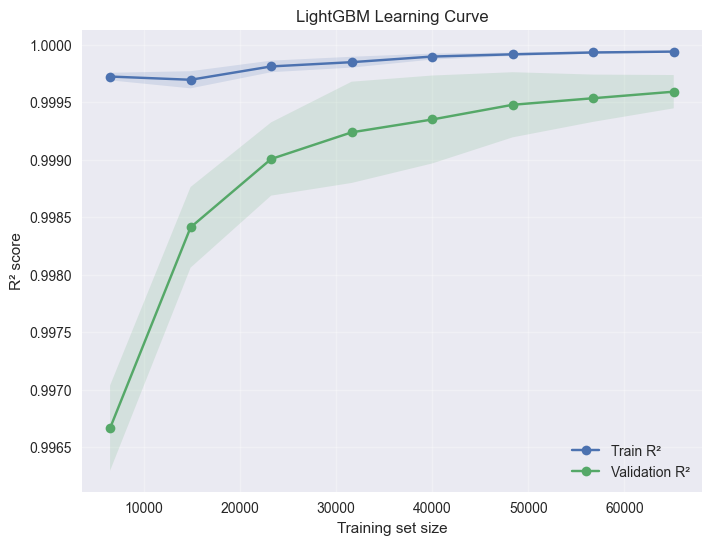

In [9]:
train_sizes, train_scores, val_scores = learning_curve(
    lgbm_final,
    X_train,
    y_train,
    cv=5,
    scoring="r2",
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 8)
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, marker="o", label="Train R²")
plt.plot(train_sizes, val_mean, marker="o", label="Validation R²")
plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.15)
plt.fill_between(train_sizes, val_mean-val_std, val_mean+val_std, alpha=0.15)
plt.title("LightGBM Learning Curve")
plt.xlabel("Training set size")
plt.ylabel("R² score")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


## 6️⃣ Global Feature Importance (LightGBM)

We first inspect **global feature importances** as provided by LightGBM.  
This highlights which variables the model relies on the most:

- Medication and lab-related features  
- Diagnosis counts  
- Demographic and admission-related variables

These results are later compared with SHAP to confirm consistency.


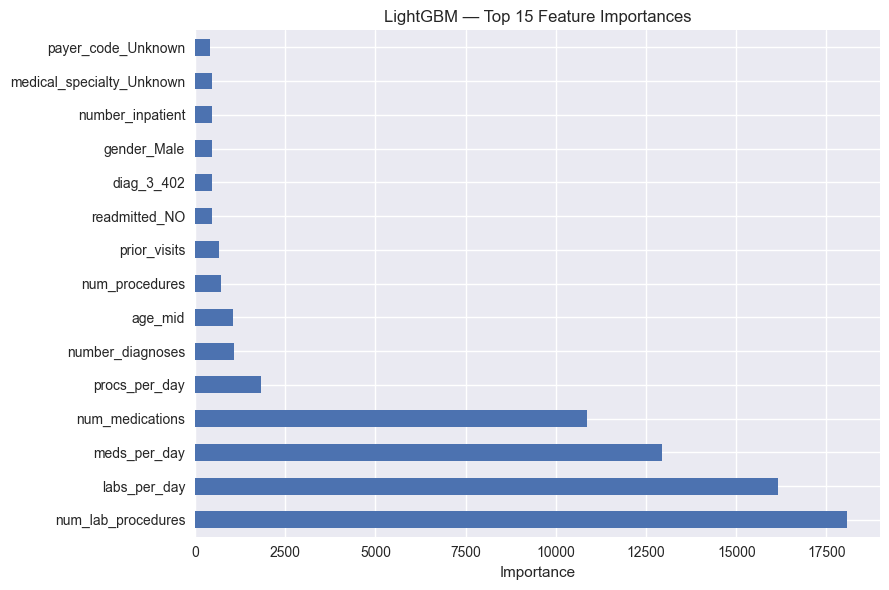

['num_lab_procedures',
 'labs_per_day',
 'meds_per_day',
 'num_medications',
 'procs_per_day',
 'number_diagnoses',
 'age_mid',
 'num_procedures',
 'prior_visits',
 'readmitted_NO',
 'diag_3_402',
 'gender_Male',
 'number_inpatient',
 'medical_specialty_Unknown',
 'payer_code_Unknown']

In [10]:
importances = pd.Series(lgbm_final.feature_importances_, index=X_train.columns)
top15 = importances.sort_values(ascending=False).head(15)

plt.figure(figsize=(9,6))
top15.sort_values().plot(kind="barh")
plt.title("LightGBM — Top 15 Feature Importances")
plt.xlabel("Importance")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

top15.index.tolist()


## 7️⃣ SHAP Global Explanation — Feature Importance (Bar)

We use **SHAP (SHapley Additive exPlanations)** to obtain a model-agnostic measure  
of feature importance based on game theory.

The bar chart shows the **mean absolute SHAP value** per feature,  
offering a robust ranking of how much each variable contributes to model predictions.


 98%|===================| 985/1000 [00:33<00:00]        

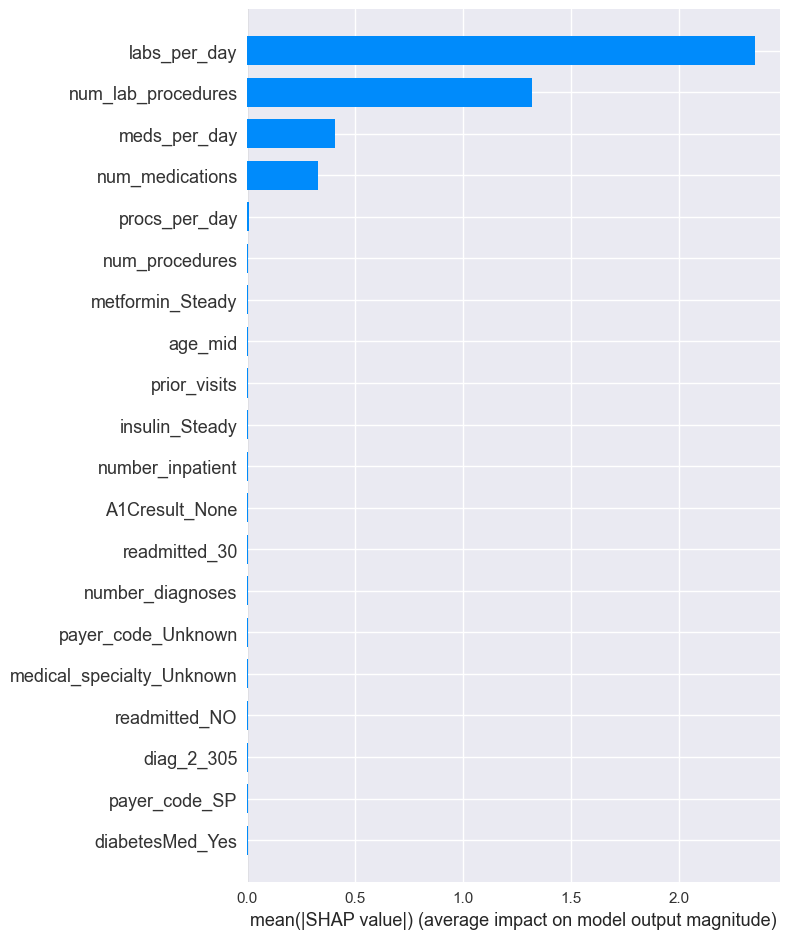

In [ ]:
# SHAP explainer
shap.initjs()

explainer = shap.Explainer(lgbm_final, X_train, feature_names=X_train.columns)
X_sample = X_test.iloc[:1000]
shap_values = explainer(X_sample)

shap.summary_plot(shap_values, X_sample, plot_type="bar", show=True)


### SHAP Summary Plot — Distribution of Effects

The summary plot displays:

- Each point = one prediction for one patient  
- Color = feature value (high vs. low)  
- Horizontal position = SHAP value (positive vs. negative impact)

This reveals not only which features are important,  
but also **how** their values impact hospital stay (increase or decrease).


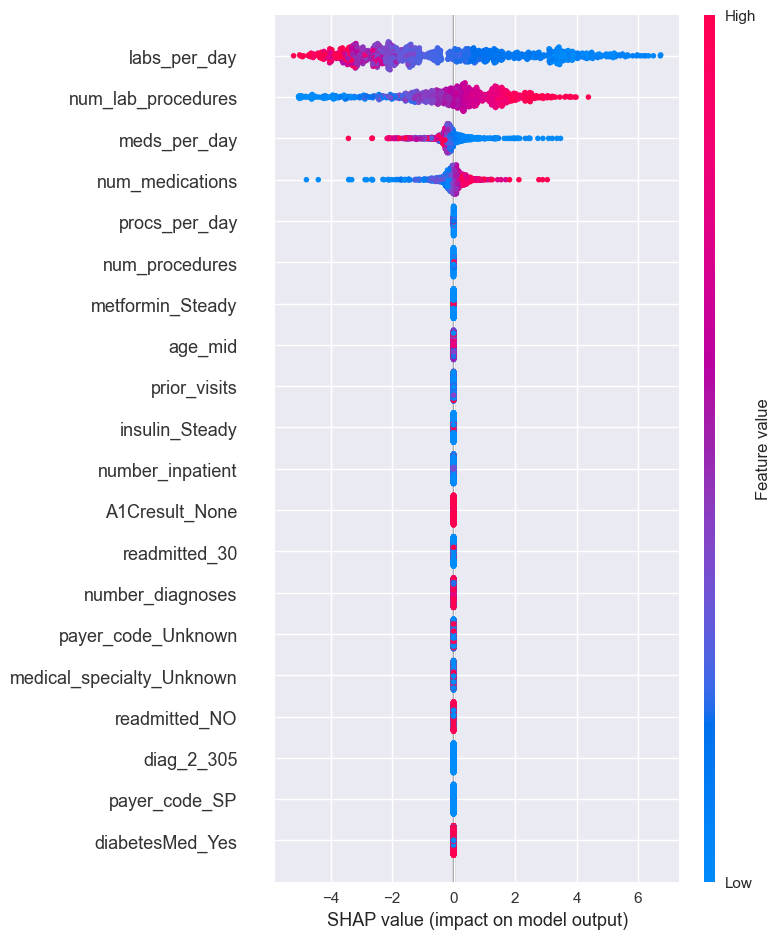

In [ ]:
shap.summary_plot(shap_values, X_sample, show=True)


## 8️⃣ Local Explanation — Single Patient (SHAP Force Plot)

To illustrate **patient-level interpretability**,  
we inspect the SHAP values for a single example:

- Red features push the prediction **up** (longer stay)  
- Blue features push the prediction **down** (shorter stay)  
- The base value represents the average model prediction

This type of explanation can support clinicians in understanding  
why the model predicts a longer or shorter hospital stay for a given patient.


In [ ]:
sample_idx = 42
x_one = X_test.iloc[sample_idx:sample_idx+1]
shap_one = explainer(x_one)

shap.initjs()
shap.force_plot(explainer.expected_value, shap_one.values, x_one)


## ✅ Summary — From Accuracy to Interpretability

In this notebook we:

- Rebuilt the final **LightGBM** model used for hospital stay prediction  
- Verified that its test performance is consistent with the training notebook  
- Inspected global feature importances  
- Applied **SHAP** to:
  - Rank key drivers of hospital stay globally  
  - Explain individual predictions at the patient level  

This demonstrates that the model is not only **highly accurate**,  
but also **transparent and clinically interpretable**,  
making it suitable as a candidate for decision-support in healthcare settings.
